### Prediction visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bag_predictions(bag, predictions, top_k=10):
    """
    Visualize a single MIL bag with predicted instance weights.
    
    Parameters:
    - bag: dict with keys:
        'protein_1' (str), 'protein_2' (str),
        'subseqs_1' (list of str), 'subseqs_2' (list of str),
        'key_indices' (list of int),
        'label' (int),
        'motif' (str)  # Make sure motif is provided in bag
    - predictions: 1D np.array or list of predicted weights, same length as number of instances in bag.
    - top_k: int, number of top subsequence pairs to display
    
    Displays:
    - Proteins with highlighted motif occurrences (in blue).
    - Table of top_k pairs sorted by predicted weight, indicating true key instances.
    """
    
    p1 = bag['protein_1']
    p2 = bag['protein_2']
    subseqs_1 = bag['subseqs_1']
    subseqs_2 = bag['subseqs_2']
    key_indices = set(bag['key_indices'])
    label = bag['label']
    motif = bag.get('motif', None)
    
    # Lengths
    n_subseqs_1 = len(subseqs_1)
    n_subseqs_2 = len(subseqs_2)
    
    # Find motif occurrences (positions) in each protein (if motif given)
    def find_motif_positions(protein, motif):
        positions = []
        if motif:
            start = 0
            while True:
                idx = protein.find(motif, start)
                if idx == -1:
                    break
                positions.extend(range(idx, idx + len(motif)))
                start = idx + 1
        return set(positions)
    
    motif_positions_1 = find_motif_positions(p1, motif)
    motif_positions_2 = find_motif_positions(p2, motif)
    
    # Visualize proteins with highlights for motif positions
    def highlight_protein(seq, motif_pos_set):
        """Return a list of tuples (char, highlight_bool)"""
        highlight_mask = [i in motif_pos_set for i in range(len(seq))]
        return [(c, h) for c, h in zip(seq, highlight_mask)]
    
    # Plot proteins
    h_protein_1 = highlight_protein(p1, motif_positions_1)
    h_protein_2 = highlight_protein(p2, motif_positions_2)
    
    fig, axs = plt.subplots(3, 1, figsize=(14, 8))
    fig.suptitle(f"Bag label: {label} - Key instances: {len(key_indices)}", fontsize=16)
    
    def plot_highlighted_sequence(ax, highlighted_seq, title):
        ax.set_title(title)
        ax.axis('off')
        for i, (char, highlight) in enumerate(highlighted_seq):
            color = 'blue' if highlight else 'black'
            bbox = dict(facecolor='lightblue', alpha=0.5) if highlight else None
            ax.text(i, 0, char, color=color, fontsize=14, fontweight='bold' if highlight else 'normal', bbox=bbox)
        ax.set_xlim(-1, len(highlighted_seq))
        ax.set_ylim(-1, 1)
    
    plot_highlighted_sequence(axs[0], h_protein_1, "Protein 1 (motif highlighted in blue)")
    plot_highlighted_sequence(axs[1], h_protein_2, "Protein 2 (motif highlighted in blue)")
    
    # Sort predicted weights descending and get top_k pairs
    pred = np.array(predictions)
    top_indices = np.argsort(pred)[::-1][:top_k]
    
    # Prepare pairs info for display
    rows = []
    for rank, idx in enumerate(top_indices, 1):
        i = idx // n_subseqs_2
        j = idx % n_subseqs_2
        s1 = subseqs_1[i]
        s2 = subseqs_2[j]
        weight = pred[idx]
        is_key = "YES" if idx in key_indices else "NO"
        rows.append((rank, i, s1, j, s2, weight, is_key))
    
    # Display table below sequences
    col_labels = ["Rank", "Subseq idx P1", "Subseq P1", "Subseq idx P2", "Subseq P2", "Predicted weight", "Is Key Instance"]
    table_data = [[str(x) for x in row] for row in rows]
    
    axs[2].axis('off')
    table = axs[2].table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Introduction

Designing a synthetic protein-protein interaction (PPI) dataset tailored for Key Instance Detection (KID) in Multi-Instance Learning (MIL) with realistic parameters involves several steps.

### 1. Dataset Parameters Should Be Realistic

**Protein length:**
Real proteins vary widely, but many typical domains and proteins range from 100 to 500 amino acids. To keep it manageable, you might simulate proteins of lengths between 100 and 300 residues. This captures small-to-medium proteins realistically.

**Amino acid alphabet:**
Use the standard 20 amino acids.

### 2. Sliding Window Approach for Bags of Subsequences

Since domain location is unknown, split each protein into overlapping subsequences (instances) using a sliding window.

Each subsequence is an instance.

Then the bag corresponds to all subsequences from both proteins concatenated or paired somehow.

### 3. Choosing Sliding Window Size

Protein domains typically vary in length but many fall within 50-150 amino acids.

Key functional motifs (shorter interaction motifs) can be even smaller (~6-20 amino acids), so the window should be around the average domain size: 80-120 amino acids.

**Sliding window parameters:**

``Window size:`` ~100 residues (tunable)

``Step size:`` maybe 10-20 residues (to create overlap and more instances)

### 4. Bag Labeling Logic

**Positive bag:** two proteins interact via a motif (or domain) but the motif location is unknown.

**Negative bag:** two proteins do not interact.

In synthetic data, it is possible embed a known interaction motif (a fixed amino acid subsequence pattern) randomly inside one subsequence of the first protein and one subsequence of the second protein, but these subsequences are hidden within bags of all subsequences.

Positive bags contain at least one pair of subsequences from the two proteins that contain this motif (the key instance).

Negative bags contain no such pair.

### 5. Bags design

Bags contain all pairs of subsequences (cross-product)

**What it means:**
You generate every pair of subsequences (a_i, b_j) from protein A and B:

**Pros:**

Much more biologically realistic: protein-protein interaction occurs via domain-domain interaction.

Each instance models a candidate interaction pair — which is ideal for key instance detection.

Enables your MIL model to explicitly identify which pair of regions causes interaction.

**Cons:**

Quadratic growth in instance count: If each protein has 20 subsequences, the bag will have 400 instances.

More computationally expensive — training MIL models on large bags can be slow.

Each instance (pair) must be encoded as a combined feature vector (e.g., concatenation, difference, outer product, or using a neural pair encoder).

In [4]:
import torch
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# MNIST dataset creation
from milearn.data.mnist import load_mnist, create_bags_or, create_bags_and, create_bags_xor
from milearn.network.module.utils import set_seed

# MIL classifiers
from milearn.network.classifier import (AttentionNetworkClassifier,
                                        TempAttentionNetworkClassifier,
                                        GatedAttentionNetworkClassifier,
                                        MultiHeadAttentionNetworkClassifier,
                                        SelfAttentionNetworkClassifier,
                                        HopfieldAttentionNetworkClassifier,
                                        DynamicPoolingNetworkClassifier)

# Utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from milearn.preprocessing import BagMinMaxScaler

In [5]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

# ==== Parameters ====
PROTEIN_LENGTH = 50
WINDOW_SIZE = 10
STEP_SIZE = 3               # sliding window step to reduce subsequences
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTVWY"
N_MOTIFS = 1
MOTIF_LENGTH = 6
N_BAGS = 1000
POS_RATIO = 0.5
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# ==== Generate Random Motifs ====
MOTIFS = ["".join(random.choices(AMINO_ACIDS, k=MOTIF_LENGTH)) for _ in range(N_MOTIFS)]

# ==== Utils ====
def generate_protein(length=PROTEIN_LENGTH):
    return "".join(random.choices(AMINO_ACIDS, k=length))

def embed_motif(protein, motif):
    start = random.randint(0, len(protein) - len(motif))
    return protein[:start] + motif + protein[start + len(motif):], start

def sliding_windows(protein, window=WINDOW_SIZE, step=STEP_SIZE):
    return [protein[i:i+window] for i in range(0, len(protein) - window + 1, step)]

def onehot_encode(seq):
    aa_to_idx = {aa: i for i, aa in enumerate(AMINO_ACIDS)}
    vec = np.zeros((len(seq), len(AMINO_ACIDS)))
    for i, aa in enumerate(seq):
        if aa in aa_to_idx:
            vec[i, aa_to_idx[aa]] = 1.0
    return vec.flatten()

# ==== Protein Pair Generation ====
def generate_protein_pair_with_motif(is_positive):
    p1 = generate_protein()
    p2 = generate_protein()

    key_indices = []
    motif = None

    if is_positive:
        motif = random.choice(MOTIFS)
        p1, idx1 = embed_motif(p1, motif)
        p2, idx2 = embed_motif(p2, motif)

        subseqs1 = sliding_windows(p1)
        subseqs2 = sliding_windows(p2)

        for i, s1 in enumerate(subseqs1):
            if motif in s1:
                for j, s2 in enumerate(subseqs2):
                    if motif in s2:
                        key_indices.append(i * len(subseqs2) + j)

    return p1, p2, key_indices, motif

# ==== Bag Construction ====
def create_bag_and_keys(p1, p2, key_indices=None, motif=None):
    subseqs1 = sliding_windows(p1)
    subseqs2 = sliding_windows(p2)

    bag = []
    key_instance_indices = []

    for i, s1 in enumerate(subseqs1):
        for j, s2 in enumerate(subseqs2):
            vec1 = onehot_encode(s1)
            vec2 = onehot_encode(s2)
            pair_vec = np.concatenate([vec1, vec2])
            bag.append(pair_vec)
            if key_indices and (i * len(subseqs2) + j) in key_indices:
                key_instance_indices.append(len(bag) - 1)

    return {
        "encoded_bag": np.stack(bag),
        "label": 1 if key_indices else 0,
        "key_indices": key_instance_indices,
        "protein_1": p1,
        "protein_2": p2,
        "subseqs_1": subseqs1,
        "subseqs_2": subseqs2,
        "motif": motif
    }

# ==== Dataset Generation ====
def generate_dataset_with_keys(n_bags=N_BAGS, pos_ratio=POS_RATIO):
    bags = []
    n_pos = int(n_bags * pos_ratio)
    n_neg = n_bags - n_pos

    print(f"Generating {n_pos} positive and {n_neg} negative bags...")

    for i in range(n_pos):
        p1, p2, key_indices, motif = generate_protein_pair_with_motif(True)
        bag_data = create_bag_and_keys(p1, p2, key_indices, motif)
        bags.append(bag_data)
        if (i + 1) % 50 == 0 or (i + 1) == n_pos:
            print(f"Generated {i + 1}/{n_pos} positive bags")

    for i in range(n_neg):
        p1, p2, _, motif = generate_protein_pair_with_motif(False)
        bag_data = create_bag_and_keys(p1, p2, None, motif)
        bags.append(bag_data)
        if (i + 1) % 50 == 0 or (i + 1) == n_neg:
            print(f"Generated {i + 1}/{n_neg} negative bags")

    print("Dataset generation complete.")
    return bags

# ==== KID Accuracy Function ====
def kid_accuracy(true_key_indices, predictions, labels, top_k=1):
    assert len(predictions) == len(true_key_indices) == len(labels)

    correct = 0
    total = 0

    for pred, true_keys, label in zip(predictions, true_key_indices, labels):
        if label != 1:
            continue
        total += 1

        if len(true_keys) == 0:
            continue

        top_pred_indices = np.argsort(pred)[-top_k:]
        if any(idx in true_keys for idx in top_pred_indices):
            correct += 1

    return correct / total if total > 0 else 0.0

### 1. Create PPI dataset

In [6]:
bags = generate_dataset_with_keys()
# 
dsc = [i["encoded_bag"] for i in bags]
labels = [i["label"] for i in bags]
key = [i["key_indices"] for i in bags]

Generating 500 positive and 500 negative bags...
Generated 50/500 positive bags
Generated 100/500 positive bags
Generated 150/500 positive bags
Generated 200/500 positive bags
Generated 250/500 positive bags
Generated 300/500 positive bags
Generated 350/500 positive bags
Generated 400/500 positive bags
Generated 450/500 positive bags
Generated 500/500 positive bags
Generated 50/500 negative bags
Generated 100/500 negative bags
Generated 150/500 negative bags
Generated 200/500 negative bags
Generated 250/500 negative bags
Generated 300/500 negative bags
Generated 350/500 negative bags
Generated 400/500 negative bags
Generated 450/500 negative bags
Generated 500/500 negative bags
Dataset generation complete.


In [7]:
bags[0]['encoded_bag'].shape

(196, 400)

In [8]:
bags[0]['motif']

'PAGFRQ'

In [9]:
bags[0]['protein_1']

'VCKAFMAEPMFNTATQHEPAGFRQTRMYINTPVNRAFGCFDGPIIFGWPP'

In [10]:
bags[0]['protein_2']

'EREIYPNQTSFAHGFWVHQIWLGFNGNPAGFRQADPSKCIYMYVARQMGP'

In [11]:
bags[0]["key_indices"]

[78, 79, 92, 93]

### 2. Build model

In [12]:
network_hparams = {'hidden_layer_sizes':(256, 128, 64,),
                   'num_epoch':100,
                   'batch_size':128,
                   'learning_rate':0.001,
                   'weight_decay':0.001,
                   'instance_weight_dropout':0.01,
                   'init_cuda':False,
                   'verbose':False}

In [13]:
x_train, x_test, y_train, y_test, key_train, key_test, seq_train, seq_test = train_test_split(
    dsc, labels, key, bags, test_size=0.2, random_state=SEED, stratify=labels
)

In [14]:
scaler = BagMinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [15]:
model = AttentionNetworkClassifier(**network_hparams)
model.to("cpu")
model.fit(x_train_scaled, y_train)

AttentionNetworkClassifier(
  (extractor): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (detector): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (estimator): Linear(in_features=64, out_features=1, bias=True)
)

In [16]:
y_prob = model.predict(x_test_scaled)
y_pred = np.where(y_prob > 0.5, 1, 0)
w_pred = model.get_instance_weights(x_test_scaled)

In [17]:
print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"KID accuracy: {kid_accuracy(key_test, w_pred, y_test, top_k=1):.2f}")

Classification accuracy: 0.99
KID accuracy: 0.99


In [18]:
# bags with correct positive class prediction (use these indexes for visualization)
np.where((y_pred == 1) & (np.array(y_test) == 1))[0]

array([  0,   2,   4,   5,   6,  12,  13,  14,  15,  20,  21,  23,  24,
        25,  27,  28,  29,  30,  35,  38,  39,  40,  43,  44,  47,  52,
        55,  59,  62,  65,  66,  67,  71,  72,  76,  77,  78,  79,  80,
        83,  86,  87,  88,  89,  90,  96,  97,  98, 101, 102, 106, 109,
       110, 111, 112, 114, 116, 117, 118, 120, 123, 124, 128, 133, 135,
       144, 145, 148, 149, 152, 153, 157, 158, 159, 161, 162, 165, 166,
       167, 169, 170, 171, 177, 179, 180, 184, 185, 189, 190, 191, 192,
       193, 194, 196, 197, 198])

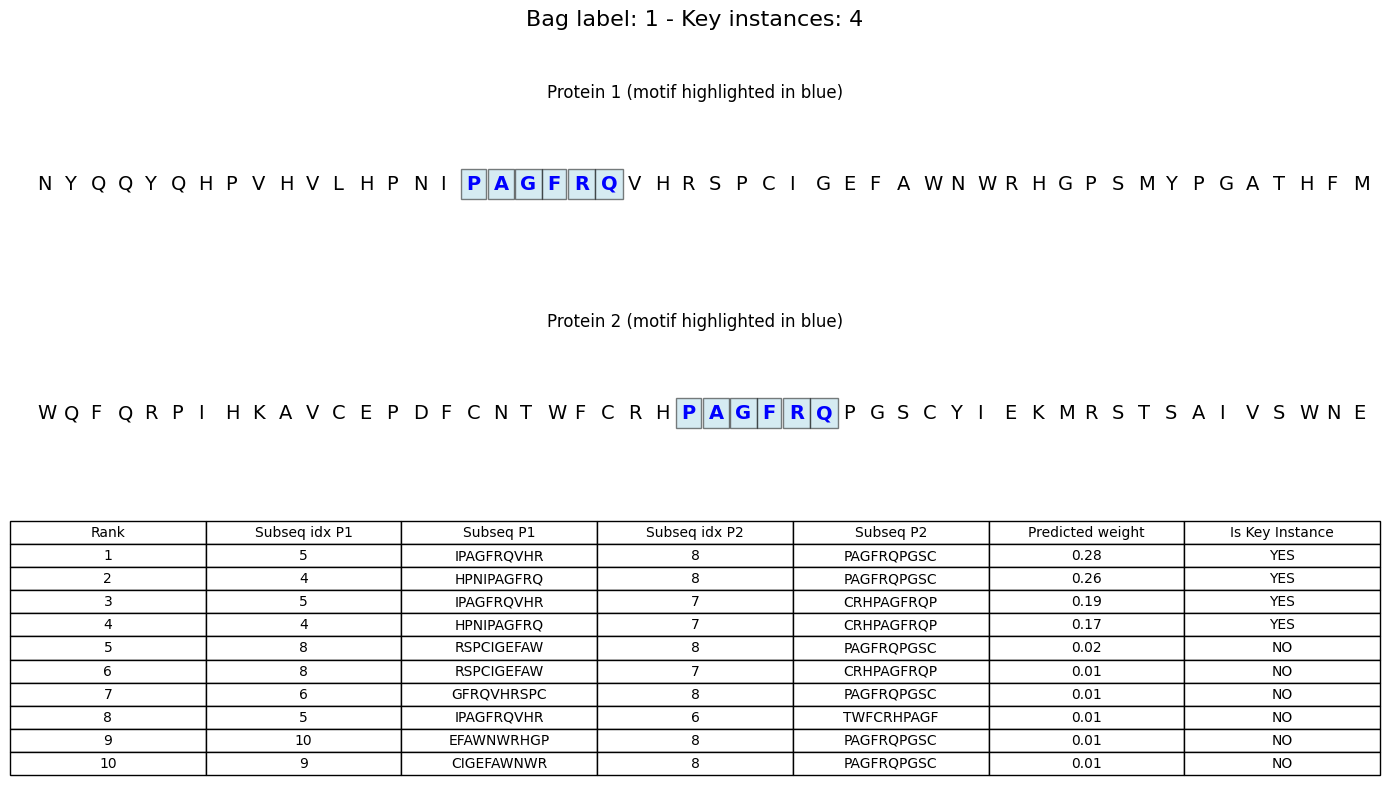

In [19]:
N = 6
visualize_bag_predictions(seq_test[N], w_pred[N].round(2), top_k=10)